In [1]:
import pointCollection as pc
import matplotlib.pyplot as plt
import numpy as np
import glob
import h5py
import re
import pdb
import scipy.sparse as sp
import pandas as pd

%matplotlib notebook

# read the saved angle information

In [2]:
spot_dir='/Volumes/ice3/ben/spot_angles/'
spots=range(1,7)
angles={spot:[] for spot in spots}
for file in glob.glob(spot_dir+'/*.h5'):
    for spot in spots:
        angles[spot] +=[pc.data().from_h5(file, group=f'spot_{spot}')]

for spot in spots:
    temp=pc.data().from_list(angles[spot])
    ind=np.argsort(temp.delta_time)
    temp=temp[ind]
    temp=temp.ravel_fields()
    good=np.argwhere(np.diff(temp.delta_time)>0).ravel()
    good = good[np.isfinite(temp.sin_coel[good])]
    print([temp.size,len(good)])
    angles[spot]=temp[good].ravel_fields()
    

[108230, 107659]
[107952, 106700]
[108172, 107540]
[107968, 106770]
[108190, 107486]
[107954, 106619]


### Plots of off-pointing coordinates over time:

In [3]:
# back-of-the-envelope estimate of the range from ICESat-2 to the surface
R0=500e3

# calculate the x and y offsets as a function of delta_time (for plotting purposes only)
xydt={}
for spot in spots:
    xydt[spot] = pc.data().from_dict({'x':R0*angles[spot].sin_coel*angles[spot].cos_az,
                  'y':R0*angles[spot].sin_coel*angles[spot].sin_az,
                  'year':angles[spot].delta_time/24/3600/365.25+2018})


<IPython.core.display.Javascript object>


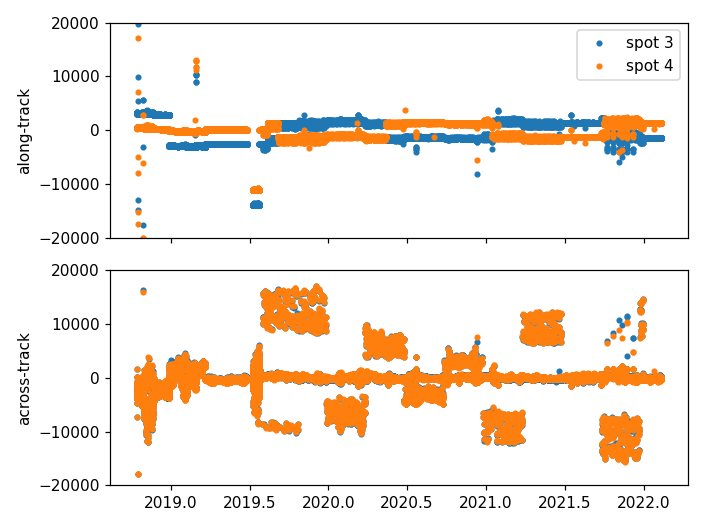

In [4]:

hf, hax=plt.subplots(2,1, sharex=True)
for spot in [3, 4]:
    hax[0].plot(xydt[spot].year, xydt[spot].x,'.', label=f'spot {spot}')
    hax[1].plot(xydt[spot].year, xydt[spot].y,'.')

plt.sca(hax[0])
plt.legend()

hax[0].set_ylabel('along-track')
hax[1].set_ylabel('across-track')

for ax in hax:
    ax.set_ylim([-20000, 20000])
plt.tight_layout()

These plots show the x and y offsets (in along-track coordinates) of the central-pair spots.  The default plot is zoomed out to $\pm$ 20 km, showing (among other things) the off pointing strategy that's helping to fill in the pole hole.  It's surprising (to me) that in the early part of the mission (Q4 of 2018 -> Q1 of 2020), when IS2 was not pointing accurately at the RGTs, the along-track pointing was unremarkable.  

### Functions for reading in crossover data

In [5]:
xover_base='/Volumes/ice3/ben/ATL06/xovers/Antarctic/r005'
# define all time values, in 10-day increments between 2018 and 2022
delta_t=10*24*3600
t_centers=np.arange(0.75*24*3600*365, (2022-2018)*24*3600*365, delta_t/2)

In [6]:
def RDE(x):
    xs=x.copy()
    xs=np.isfinite(xs)   # this changes xs from values to a boolean
    if np.sum(xs)<2 :
        return np.nan
    ind=np.arange(0.5, np.sum(xs))
    LH=np.interp(np.array([0.16, 0.84])*np.sum(xs), ind, np.sort(x[xs]))
    #print('LH =',LH)
    return (LH[1]-LH[0])/2.  # trying to get some kind of a width of the data ~variance

def read_xovers(file, fields=None):
    '''
    Read crossovers from a saved crossover file
    
    Inputs :
    File (str): hdf-5 file to read
    fields (list of strs): fields to read from the file
    
    Returns:
    v (pc.data) field values interpolated to the crossover location
    d (pc.data) Differences between the interpolated field values 
    m (pc.data) Metadata fields for each crossover location, including grounded status, slope, and location
    data (list of pc.data objects) raw data read from each crossover file
    '''
    
    if fields is None:
        fields=['x','y','delta_time','h_li','h_li_sigma','h_mean','spot', 'rgt', 'dh_fit_dx','dh_fit_dy','atl06_quality_summary', 'latitude']
    
    m = pc.data().from_h5(file, field_dict={None:['grounded','x','y','slope_x','slope_y']})
    v=pc.data(columns=2)
    data = [pc.data(columns=2).from_h5(file, field_dict={group:fields+['W']}) for group in ['data_0','data_1']]

    
    # get ascending-vs-descending status
    asc=np.zeros([m.x.shape[0],2])
    for ii, data_i in enumerate(data):
        asc[:,ii] = data_i.latitude[:,1] > data_i.latitude[:,0]
    
    m.assign({'asc_minus_desc': (asc[:,0]==0) & (asc[:,1]==1)})
    m.assign({'desc_minus_asc': (asc[:,0]==1) & (asc[:,1]==0)})
    
    d=pc.data()
    for field in fields:
        if field=='W':
            continue
        temp = np.zeros((m.size, 2))
        for col in [0, 1]:
            temp[:, col] = np.sum(data[col].W * getattr(data[col], field), axis=1)
        
        if field in ['rgt','cycle','spot']:
            # integer fields:
            v.assign({ field : np.round(temp).astype(int)})
        else:
            v.assign({ field : temp})
            
        d.assign({ field : np.diff(temp, axis=1)})
    for item in [v, d]:
        item.__update_size_and_shape__()

    return v, d, m, data

def filter_xovers(v, d, m, data, 
                  slope_max = 0.2, grounded_tol = 0.99, 
                  asc_minus_desc=None, max_delta_t = None):
    '''
    Filter the crossovers based on field values
    '''

    good=np.all(v.atl06_quality_summary < 0.01, axis=1)
    for di in data:
        good &= np.abs(di.delta_time[:,1]-di.delta_time[:,0]) < 0.005
    good &= m.grounded > grounded_tol
    good &= np.all(np.abs(np.c_[v.dh_fit_dx, v.dh_fit_dy])< slope_max, axis=1)
    
    if asc_minus_desc is not None:
        good &= (m.asc_minus_desc == asc_minus_desc)
    else:
        good &= (m.asc_minus_desc | m.desc_minus_asc)
    if max_delta_t is not None:
        good &= (v.delta_t[:,1]-v.delta_t[:,0]) < max_delta_t
    
    v.index(good)
    d.index(good)
    m.index(good)
    for di in data:
        di.index(good)

def collect_xovers(xy0, W, cycles, xover_base, asc_minus_desc=None, max_delta_t = 24*3600*30):
    ''' Read all crossovers for a square region
    '''
    tile_re=re.compile('E(.*)_N(.*).h5')
    xi, yi = xy0
    
    v, d, m, D0, D1 = [[], [], [], [], []]
    for cycle in cycles:
        files=glob.glob(xover_base+f'/c{cycle:02d}/E*.h5')
        for file in files:
            try:
                xy=np.c_[[int(xx) for xx in tile_re.search(file).groups()]]
                if (xy[0] <= xi-W/2) | (xy[0] > xi+W/2) | \
                    (xy[1] <= yi-W/2) | (xy[1] > yi+W/2):
                    continue
                vv, dd, mm, DD = read_xovers(file)
                filter_xovers(vv, dd, mm, DD, asc_minus_desc=asc_minus_desc)
                v += [vv]
                d += [dd]
                m += [mm]
                D0 += [DD[0]]
                D1 += [DD[1]]
            except Exception as e:
                print(e)
                pass
    v=pc.data(columns=2).from_list(v)
    d=pc.data().from_list(d)
    m=pc.data().from_list(m)
    D0=pc.data(columns=2).from_list(D0)
    D1=pc.data(columns=2).from_list(D1)
    return v, d, m, D0, D1

## Read in the crossovers

In [7]:
if True:
    v, d, m, D0, D1 = [[], [], [], [], []]
    for xy in [[0, 8e5], [8e5, 8e5], [8e5,0]]:
        print(xy)
        v0, d0, m0, Di0, Di1 = collect_xovers(xy, 2.e5, np.arange(1, 14), xover_base, max_delta_t = 5*24*3600)
        v += [v0]
        d += [d0]
        m += [m0]
        D0 += [Di0]
        D1 += [Di1]
        print([v0.shape, Di0.shape, Di1.shape])
    v=pc.data(columns=2).from_list(v)
    d=pc.data().from_list(d)
    m=pc.data().from_list(m)
    D0=pc.data(columns=2).from_list(D0)
    D1=pc.data(columns=2).from_list(D1)

if True:
    for ii, DD in enumerate([D0, D1, v]):
        temp={field:np.zeros_like(v.delta_time) for field in angles[1].fields}
        for spot, ang in angles.items():
            for col in [0, 1]:
                these=np.argwhere(DD.spot[:,col]==spot)
                for field in ang.fields:
                    temp[field][these,col]=np.interp(DD.delta_time[these,col], ang.delta_time, getattr(ang, field))
        DD.assign(temp)
    for field in ang.fields:
        temp=getattr(v, field)
        d.assign({field:temp[:,1]-temp[:,0]})

    H_IS = 6859.07*1.e3 + 9000 # nearly circular, add 9 km to match Scott's calculation 511 km at the poles
    R_WGS84=6356752.314  # semi-minor axis
    
    # calculate spot geometry
    H0 = H_IS - (R_WGS84 + v.h_li)
    
    for DD in [D0, D1, v]:
        rho = H0*DD.sin_coel/DD.cos_coel
        DD.assign({'x_sp':rho*DD.cos_az,
              'y_sp':rho*DD.sin_az})
    d.assign({'x_sp':v.x_sp[:,1]-v.x_sp[:,0], 
             'y_sp':v.y_sp[:,1]-v.y_sp[:,0]})


[0, 800000.0]
[(432118, 2), (432118, 2), (432118, 2)]
[800000.0, 800000.0]
[(209038, 2), (209038, 2), (209038, 2)]
[800000.0, 0]
[(572979, 2), (572979, 2), (572979, 2)]


In [22]:
# [Don't] remove crossovers containing really large off-nadir offsets
if False:
    good = np.all(np.abs(v.x_sp) < 8000, axis=1) & np.all(np.abs(v.y_sp) < 5000, axis=1)
    print(np.mean(good))
    v.index(good)
    d.index(good)
    m.index(good)
    for Di in [D0, D1]:
        Di.index(good)

In [23]:
csv_file='spot_and_xy_biases_rel005.csv'
import pandas as pd
df=pd.read_csv(csv_file)
#def read_correction_csv(csv_file):
for d_i in [v, D0, D1]:
    d_i.assign({field: np.interp(d_i.delta_time, np.array(df.delta_time), np.array(df[field])) for field in ['x_bias', 'y_bias']})
        

### sketch solution for a correction for spot locations and height errors:

$$ 
    h = h_{sat} + R(\hat{b}\cdot\hat{z})
$$
where $h_{sat}$ is the height of the satellite, $\hat{b}$ is the beam vector, and $\hat{z}$ is the local vertical.

In terms of the x any y components of the beam vector, $\mathbf{b}$:
$$
    h = h_{sat} - (R^2 - b_x^2 - b_y^2)^{1/2}
$$
taking derivatives WRT $b_x$ and $b_y$, the displacements on the ground between the spot geolocations and nadir:
$$
    dh/db_j = \frac{b_j}{h_{sat}-h}
$$
so the error in any beam height is:
$$
    e_h \approx e_x \frac{b_x}{h_{sat}-h} + e_y \frac{b_y}{h_{sat}-h}
$$
where $e_x$ and $e_y$ are the components of the geolocation error vector.

The difference in heights between two spots ($ie.$ a crossover error) is then:
$$
    e_{h1}-e_{h0} = e_x \frac{b_{x1}-b_{x0}}{h_{sat}-h} +e_y \frac{b_{y1}-b_{y0}}{h_{sat}-h}
$$
We can collect the components of this equation for each 10-day period, and calculate a least-squares solution for $e_x$ and $e_y$ based on measured $h_1-h_0$.  $b_x$,  $b_y$ and $h$ are straightforward to calculate from variables on ATL06, and $h_{sat}$ can be derived from WGS84 and the ICESat-2 orbit.

<class 'pointCollection.data.data'> with shape (1214135, 2),
with fields:
['latitude', 'h_li_sigma', 'atl06_quality_summary', 'dh_fit_dx', 'y', 'x', 'delta_time', 'spot', 'h_li', 'dh_fit_dy', 'h_mean', 'rgt', 'cos_coel', 'sin_coel', 'sin_az', 'cos_az', 'x_sp', 'y_sp', 'x_bias', 'y_bias', 'bias_h']

In [25]:
# assign the h bias
H0 = H_IS - (R_WGS84 + v.h_li)
v.assign({'bias_h' : v.x_bias*v.x_sp/H0 + v.y_bias*v.y_sp/H0})
d.assign({'bias_h': v.bias_h[:,1]-v.bias_h[:,0]})

<class 'pointCollection.data.data'> with shape (1214135,),
with fields:
['latitude', 'h_li_sigma', 'atl06_quality_summary', 'dh_fit_dx', 'y', 'x', 'delta_time', 'spot', 'h_li', 'dh_fit_dy', 'h_mean', 'rgt', 'cos_coel', 'sin_coel', 'sin_az', 'cos_az', 'x_sp', 'y_sp', 'bias_h']

### Bin the crossovers

The crossovers are already limited to $t_1-t_0$ < 10 days.  Bin the crossovers in time by the mean of the first and last times, with one bin every 5 days.  The minimum and maximum times included in the differences in any one bin should range from $t_{ctr}-7.5d$ to $t_{ctr}+7.5d$.

In [26]:

ctr_t_tol = 5*24*3600

uT, t_bins = pc.unique_by_rows(np.round(np.mean(v.delta_time, axis=1)/ctr_t_tol)*ctr_t_tol, return_dict=True)


### Calculate the per-bin crossover statistics
There is no h_satellite parameter on ATL06, so we'll approximate it based on polar WGS84 (the semi-minor axis) and the ICESat-2 orbit radius (close enough to circular).

In [27]:
H_IS = 6859.07*1.e3 + 9000  # apogee (but the orbit is nearly circular) Add 9 km to get 511 km HAE
R_WGS84=6356752.314  # semi-minor axis

out_spot=[]
out_xy=[]
out_spot_residual = []
bin_t_tol = 10*24*3600
sigma_uncorr=np.zeros(len(t_bins))+np.NaN
sigma_corr=sigma_uncorr.copy()
out_ind=-1
for this_t, ind in t_bins.items():
    out_ind += 1
    ind_sub = ind[np.all(np.abs(v.delta_time[ind,:]-this_t) < bin_t_tol/2, axis=1)]
    if len(ind_sub) < 100:
        continue
    good=np.ones_like(ind_sub, dtype=bool)
    good_last=good==0
    count=0
    dh = d.h_li[ind_sub]
    dh_bias = d.bias_h[ind_sub]
    while np.any(np.logical_xor(good, good_last)) and count<10:
        count +=1
        sigma_h = RDE(dh[good])
        good_last=good
        good &= (np.abs(dh) < np.maximum(0.1, 3*sigma_h))
    
    if np.sum(good) > 100:
        sigma_uncorr[out_ind] = np.std(dh[good])
        sigma_corr[out_ind] = np.std(dh[good]-dh_bias[good])

<IPython.core.display.Javascript object>


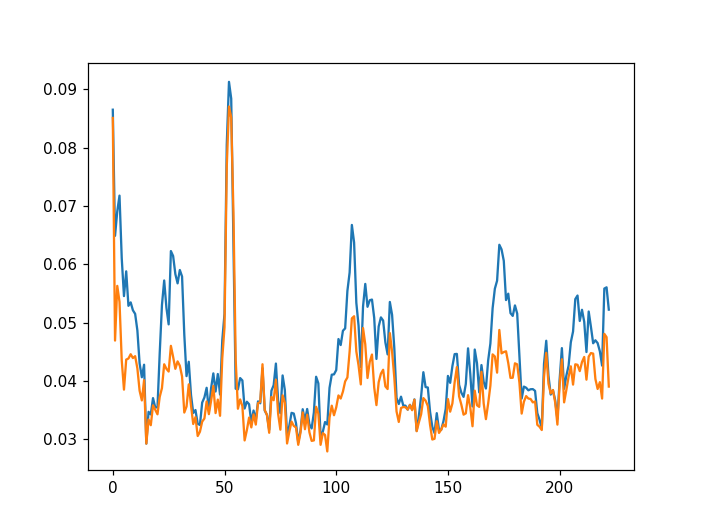

In [28]:
plt.figure()
plt.plot(sigma_uncorr)
plt.plot(sigma_corr)

In [29]:
# check that out crossovers work
def x_point(A, B):
    '''
    find the point at which vectors A and B cross
    '''

    dA=A[:,1]-A[:,0]
    dB=B[:,1]-B[:,0]
    det=-np.imag(dA*(dB.conjugate()))
    
    dAB0=A[:,0]-B[:,0]
    lA=np.imag(dAB0*(dB.conjugate()))/det
    lB=np.imag(dAB0*(dA.conjugate()))/det

    return A[:,0]+lA*dA, [lA, lB]

In [30]:
xy_0 = D0.x+1j*D0.y
xy_1 = D1.x+1j*D1.y

xy, L= x_point(xy_0, xy_1)
np.std(L[0]-D0.W[:,1])

0.0

## Note: 
correct_xy could have the biases added or subtracted.  Subtracting the biases seems to give lower residuals

In [31]:
def correct_xy(D):
    xy=D.x+1j*D.y
    x_hat = xy[:,1]-xy[:,0]
    x_hat /= np.abs(x_hat)
    y_hat = 1j*x_hat

    return xy - np.tile(x_hat[:, None], [1, 2])*D.x_bias - np.tile(y_hat[:, None], [1, 2])*D.y_bias
 
xy_c0 = correct_xy(D0)
xy_c1 = correct_xy(D1)

xy_c, L_c = x_point(xy_c0, xy_c1)

v_c = pc.data().from_dict({
    field: np.c_[np.sum(getattr(D0, field)*np.c_[1-L_c[0], L_c[0]], axis=1), \
                 np.sum(getattr(D1, field)*np.c_[1-L_c[1], L_c[1]], axis=1)]\
    for field in D0.fields
})

d_c = pc.data().from_dict({
    field:np.diff(getattr(v_c, field), axis=1)\
    for field in v_c.fields
})




<IPython.core.display.Javascript object>


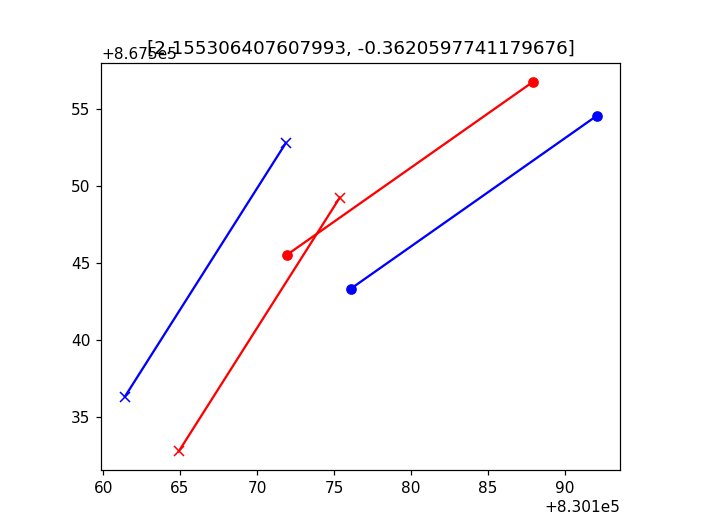

[-4.188223103125041, -4.860926243061561]
[2.1190616549663286, -1.1309262791236658]


In [32]:
bad_2 = np.flatnonzero((L_c[0]>2 ) | (L_c[1]>2))[500]
plt.figure()
plt.plot(D0.x[bad_2,:], D0.y[bad_2,:],'r', marker='o')
plt.plot(D1.x[bad_2,:], D1.y[bad_2,:],'r', marker='x')

plt.plot(np.real(xy_c0[bad_2,:]),np.imag(xy_c0[bad_2,:]), 'b', marker='o')
plt.plot(np.real(xy_c1[bad_2,:]),np.imag(xy_c1[bad_2,:]), 'b', marker='x')

plt.gca().set_title([L_c[0][bad_2], L_c[1][bad_2]])
plt.gca().set_aspect(1)

print([D0.y_bias[bad_2,0], D1.y_bias[bad_2,0]])
print([D0.x_bias[bad_2,0], D1.x_bias[bad_2,0]])


In [33]:
L_c1=np.c_[L_c].T
sigma_corr2=np.zeros(len(t_bins))+np.NaN
sigma_corr2a = sigma_corr2.copy()
out_ind=-1
for this_t, ind in t_bins.items():
    out_ind += 1
    ind_sub = ind[np.all(np.abs(v.delta_time[ind,:]-this_t) < bin_t_tol/2, axis=1)]
    if len(ind_sub) < 100:
        continue
    good=np.ones_like(ind_sub, dtype=bool)
    good_last=good==0
    count=0
    dh = d_c.h_li.ravel()[ind_sub]
    dh_bias = d.bias_h[ind_sub]
    while np.any(np.logical_xor(good, good_last)) and count<10:
        count +=1
        sigma_h = RDE(dh[good])
        good_last=good
        good = (np.abs(dh) < np.maximum(0.1, 3*sigma_h))
    
    if np.sum(good) > 100:
        dh_c = d_c.h_li[ind_sub]
        sigma_corr2[out_ind] = np.std(dh_c[good]-dh_bias[good])
        sigma_corr2a[out_ind] = np.std(dh_c[good])

<IPython.core.display.Javascript object>


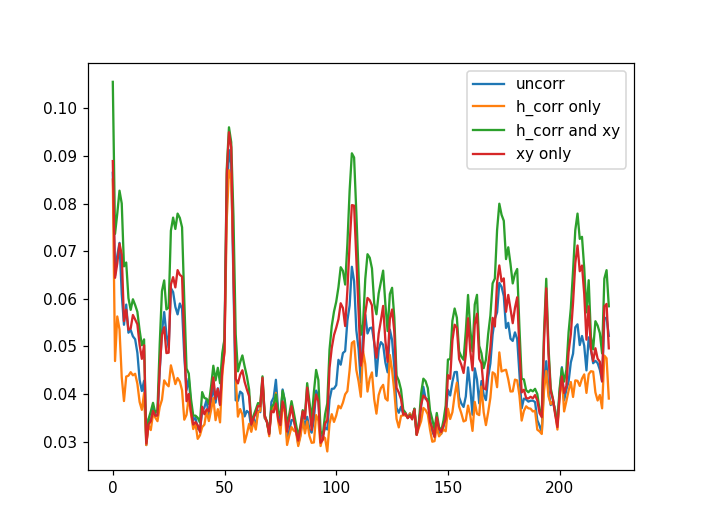

In [34]:
plt.figure()
plt.plot(sigma_uncorr, label='uncorr')
plt.plot(sigma_corr, label='h_corr only')
plt.plot(sigma_corr2, label='h_corr and xy')
plt.plot(sigma_corr2a, label='xy only')
plt.legend()

<IPython.core.display.Javascript object>


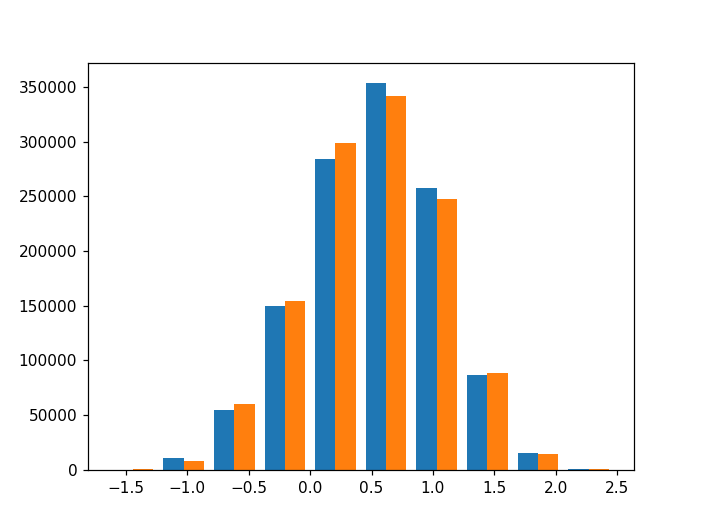

(array([[   379.,  11016.,  54471., 149576., 284333., 353724., 257285.,
          87039.,  15441.,    871.],
        [   467.,   8015.,  59857., 154249., 298310., 341777., 247727.,
          88479.,  14769.,    485.]]),
 array([-1.64816408e+00, -1.23596137e+00, -8.23758656e-01, -4.11555943e-01,
         6.46769827e-04,  4.12849483e-01,  8.25052196e-01,  1.23725491e+00,
         1.64945762e+00,  2.06166034e+00,  2.47386305e+00]),
 <a list of 2 BarContainer objects>)

In [37]:
plt.figure()
plt.hist(np.c_[L_c].T)

In [35]:
np.c_[L].shape

(2, 1214135)